In [1]:
!pip install datasets 
!pip install tokenizers 
!pip install transformers 
!pip install seqeval 
!pip install accelerate

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [1]:
import pandas as pd
from datasets import Dataset, ClassLabel, Sequence, Features, Value, DatasetDict

from transformers import AutoTokenizer

from transformers import DataCollatorForTokenClassification

import torch
from torch.utils.data import DataLoader
from transformers import AutoModelForTokenClassification
import numpy as np
# from datasets import load_metric
import evaluate
from transformers import TrainingArguments, Trainer

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Preprocess

In [2]:
train_data_path = "train.txt"
val_data_path = "valid.txt"
test_data_path = "test.txt"

In [3]:
def read_ner_txt(path):
    with open(path, 'r') as f:
        text = f.readlines()
        text = [i.rstrip('\n') for i in text]
    tokens_list = []
    ner_tags_list = []
    temp_vocab = ''
    temp_label = ''

    for item in text:
        if item == '' or item == '.':  # Empty line or period indicates a new segment
            if temp_vocab:  # Only append if temp_vocab is not empty
                tokens_list.append(temp_vocab)
                ner_tags_list.append(temp_label)
                temp_vocab = ''
                temp_label = ''
        else:
            parts = item.split(' ')
            if len(parts) == 2:  # Ensure the line has both token and label
                vocab, label = parts
                temp_vocab += ' ' + vocab
                temp_label += ' ' + label

    # Append the last segment if it exists
    if temp_vocab:
        tokens_list.append(temp_vocab)
        ner_tags_list.append(temp_label)

    return tokens_list, ner_tags_list

In [4]:
# Read the training data
train_tokens, train_ner_tags = read_ner_txt(train_data_path)

# Read the validation data
val_tokens, val_ner_tags = read_ner_txt(val_data_path)

# Read the test data
test_tokens, test_ner_tags = read_ner_txt(test_data_path)

print(train_tokens[:2])  # Check the first token and its corresponding NER tag
print(train_ner_tags[:2])  # Check the first NER tag

all_tags = []
for tags in train_ner_tags:
    all_tags.extend(tags.strip().split())

tag_name = sorted(set(all_tags))

print(tag_name)

[' The admin@338 has largely targeted organizations involved in financial , economic and trade policy , typically using publicly available RATs such as Poison Ivy , as well some non-public backdoors .', ' The admin@338 started targeting Hong Kong media companies , probably in response to political and economic challenges in Hong Kong and China .']
[' O B-HackOrg O O O O O O B-Idus O B-Idus O B-Idus I-Idus O O O B-Tool I-Tool I-Tool O O B-Tool I-Tool O O O O B-Tool I-Tool O', ' O B-HackOrg O O B-Area I-Area B-Org I-Org O O O O O B-Idus O B-Idus O O B-Area I-Area O B-Area O']
['B-Area', 'B-Exp', 'B-Features', 'B-HackOrg', 'B-Idus', 'B-OffAct', 'B-Org', 'B-Purp', 'B-SamFile', 'B-SecTeam', 'B-Time', 'B-Tool', 'B-Way', 'I-Area', 'I-Exp', 'I-Features', 'I-HackOrg', 'I-Idus', 'I-OffAct', 'I-Org', 'I-Purp', 'I-SamFile', 'I-SecTeam', 'I-Time', 'I-Tool', 'I-Way', 'O']


In [5]:
def list_to_dataframe(tokens_list, ner_tags_list):
  df = pd.DataFrame(zip(tokens_list,ner_tags_list), columns = ['tokens','ner_tags'])
  assert all(i for i in ['tokens','ner_tags'] if i in df.columns) 

  # pre-processing
  df = df.dropna()
  df = df.drop(df[df['tokens']==''].index.values, )
  df = df.reset_index(drop=True)
  df['tokens'] = df['tokens'].map(lambda x: x.strip().split(' '))
  df['ner_tags'] = df['ner_tags'].map(lambda x: x.strip().split(' '))
  # df.head()
  return df

In [6]:
df = list_to_dataframe(train_tokens, train_ner_tags)
valid_df = list_to_dataframe(val_tokens, val_ner_tags)
test_df = list_to_dataframe(test_tokens, test_ner_tags)

print(df) # Check the first two rows of the DataFrame

                                                 tokens  \
0     [The, admin@338, has, largely, targeted, organ...   
1     [The, admin@338, started, targeting, Hong, Kon...   
2     [Multiple, China-based, cyber, threat, groups,...   
3     [The, admin@338, has, targeted, international,...   
4     [In, August, 2015, ,, the, admin@338, sent, sp...   
...                                                 ...   
5246  [However, ,, even, though, the, TTPs, of, the,...   
5247  [In, several, cases, ,, the, Cobalt, compromis...   
5248  [To, ensure, remote, access, to, the, workstat...   
5249  [In, a, recent, spear-phishing, campaign, ,, t...   
5250  [Gallmaker, used, lure, documents, attempt, to...   

                                               ner_tags  
0     [O, B-HackOrg, O, O, O, O, O, O, B-Idus, O, B-...  
1     [O, B-HackOrg, O, O, B-Area, I-Area, B-Org, I-...  
2     [O, B-Area, B-HackOrg, I-HackOrg, I-HackOrg, O...  
3     [O, B-HackOrg, O, O, B-Org, I-Org, I-Org, O, O...  
4

In [7]:
tags = ClassLabel(num_classes=len(tag_name), names=tag_name)

dataset_structure = {"ner_tags":Sequence(tags),
                 'tokens': Sequence(feature=Value(dtype='string'))}

In [8]:
def df_to_dataset(df, columns=['ner_tags', 'tokens']):
  assert set(['ner_tags', 'tokens']).issubset(df.columns)

  ner_tags = df['ner_tags'].map(tags.str2int).values.tolist()
  tokens = df['tokens'].values.tolist()

  assert isinstance(tokens[0], list)
  assert isinstance(ner_tags[0], list)
  d = {'ner_tags':ner_tags, 'tokens':tokens}
  # create dataset
  dataset = Dataset.from_dict(mapping=d,
              features=Features(dataset_structure),)
  return dataset

train_dataset = df_to_dataset(df) 
valid_dataset = df_to_dataset(valid_df)
test_dataset = df_to_dataset(test_df) 

In [9]:
dataset = DatasetDict({
    'train': train_dataset, 
    'test': test_dataset,
    'valid': valid_dataset}) 

label_names = dataset["train"].features["ner_tags"].feature.names

print(dataset) # Check the dataset structure
print(label_names) # Check the label names

DatasetDict({
    train: Dataset({
        features: ['ner_tags', 'tokens'],
        num_rows: 5251
    })
    test: Dataset({
        features: ['ner_tags', 'tokens'],
        num_rows: 664
    })
    valid: Dataset({
        features: ['ner_tags', 'tokens'],
        num_rows: 662
    })
})
['B-Area', 'B-Exp', 'B-Features', 'B-HackOrg', 'B-Idus', 'B-OffAct', 'B-Org', 'B-Purp', 'B-SamFile', 'B-SecTeam', 'B-Time', 'B-Tool', 'B-Way', 'I-Area', 'I-Exp', 'I-Features', 'I-HackOrg', 'I-Idus', 'I-OffAct', 'I-Org', 'I-Purp', 'I-SamFile', 'I-SecTeam', 'I-Time', 'I-Tool', 'I-Way', 'O']


## Train and Eval

In [11]:
#check if gpu is present
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
data_collator = DataCollatorForTokenClassification(tokenizer)

model = AutoModelForTokenClassification.from_pretrained("distilbert-base-uncased", num_labels=len(label_names))
model.to(device)

def tokenize_function(examples):
    return tokenizer(examples["tokens"], padding="max_length",
                     truncation=True, is_split_into_words=True)

tokenized_datasets_ = dataset.map(tokenize_function, batched=True)

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 662/662 [00:00<00:00, 9265.47 examples/s]


In [25]:
#Get the values for input_ids, attention_mask, adjusted labels
def tokenize_adjust_labels(all_samples_per_split):
  tokenized_samples = tokenizer.batch_encode_plus(all_samples_per_split["tokens"],
                is_split_into_words=True, truncation=True)
  # print(tokenized_samples['input_ids'][:2])
  # tokenizer(string, padding=True, truncation=True)
  # assert False
  print(len(tokenized_samples["input_ids"]))
  print(tokenized_samples.word_ids(batch_index=2))
  total_adjusted_labels = []

  for k in range(0, len(tokenized_samples["input_ids"])):
    prev_wid = -1
    word_ids_list = tokenized_samples.word_ids(batch_index=k)
    existing_label_ids = all_samples_per_split["ner_tags"][k]
    i = -1
    adjusted_label_ids = []
    # print(existing_label_ids)
    # print(adjusted_label_ids)
    # assert False
    for word_idx in word_ids_list:
      # Special tokens have a word id that is None. We set the label to -100 so they are automatically
      # ignored in the loss function.
      if(word_idx is None):
        adjusted_label_ids.append(-100)
      elif(word_idx!=prev_wid):
        i = i + 1
        adjusted_label_ids.append(existing_label_ids[i])
        prev_wid = word_idx
      else:
        label_name = label_names[existing_label_ids[i]]
        adjusted_label_ids.append(existing_label_ids[i])

    total_adjusted_labels.append(adjusted_label_ids)

  #add adjusted labels to the tokenized samples
  tokenized_samples["labels"] = total_adjusted_labels
  return tokenized_samples

tokenized_dataset = dataset.map(tokenize_adjust_labels,
                batched=True,
                remove_columns=list(dataset["train"].features.keys()))

Map:  95%|█████████▌| 5000/5251 [00:00<00:00, 17400.62 examples/s]

1000
[None, 0, 1, 1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, None]
1000
[None, 0, 1, 1, 2, 3, 4, 5, 5, 5, 6, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 16, 16, 16, 16, 17, 18, 18, 18, 19, 20, 21, None]
1000
[None, 0, 1, 2, 3, 4, 5, 6, 7, 7, 8, 9, 10, 11, 12, 13, 14, 14, 14, 14, 15, 16, 17, 18, 19, 20, 21, None]
1000
[None, 0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 15, 16, 16, 17, None]
1000
[None, 0, 1, 2, 3, 4, 4, 5, 6, 7, 8, 9, 9, 10, 11, 12, 13, 14, 15, 15, 16, 17, 18, 19, 20, 21, 21, 21, 21, 21, 21, 21, 22, 23, 24, 25, 26, None]
251
[None, 0, 0, 0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 8, 9, 10, 11, 11, 11, 12, 13, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 27, 28, None]


Map: 100%|██████████| 664/664 [00:00<00:00, 21218.38 examples/s]


664
[None, 0, 0, 1, 2, 3, 4, 5, 6, 7, 7, 7, 8, 9, 9, 9, 10, 11, 12, None]


Map: 100%|██████████| 662/662 [00:00<00:00, 20075.84 examples/s]

662
[None, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, None]


In [13]:
out = tokenizer("Fine tune NER in google colab!")
out

{'input_ids': [101, 2986, 8694, 11265, 2099, 1999, 8224, 15270, 2497, 999, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [14]:
out.word_ids(0)

[None, 0, 1, 2, 2, 3, 4, 5, 5, 6, None]

In [33]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 5251
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 664
    })
    valid: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 662
    })
})

In [16]:
metric = evaluate.load("seqeval")

# metric = load_metric("seqeval")

def compute_metrics(p):
    predictions, labels = p

    #select predicted index with maximum logit for each token
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_names[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [17]:
from transformers import TrainerCallback
import numpy as np

class MetricsRecorder(TrainerCallback):
    def __init__(self):
        self.train_losses = []
        self.eval_losses = []
        self.train_accuracies = []
        self.eval_accuracies = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            if 'loss' in logs:
                self.train_losses.append(logs['loss'])
            if 'eval_loss' in logs:
                self.eval_losses.append(logs['eval_loss'])
            if 'eval_accuracy' in logs:
                self.eval_accuracies.append(logs['eval_accuracy'])
            if 'train_accuracy' in logs:  # 若 compute_metrics 回傳
                self.train_accuracies.append(logs['train_accuracy'])

recorder = MetricsRecorder()

In [18]:
example = dataset["train"][1]
labels = [label_names[i] for i in example[f"ner_tags"]]
metric.compute(predictions=[labels], references=[labels])

{'Area': {'precision': np.float64(1.0),
  'recall': np.float64(1.0),
  'f1': np.float64(1.0),
  'number': np.int64(3)},
 'HackOrg': {'precision': np.float64(1.0),
  'recall': np.float64(1.0),
  'f1': np.float64(1.0),
  'number': np.int64(1)},
 'Idus': {'precision': np.float64(1.0),
  'recall': np.float64(1.0),
  'f1': np.float64(1.0),
  'number': np.int64(2)},
 'Org': {'precision': np.float64(1.0),
  'recall': np.float64(1.0),
  'f1': np.float64(1.0),
  'number': np.int64(1)},
 'overall_precision': np.float64(1.0),
 'overall_recall': np.float64(1.0),
 'overall_f1': np.float64(1.0),
 'overall_accuracy': 1.0}

In [19]:
batch_size = 128
logging_steps = len(tokenized_dataset['train']) // batch_size
epochs = 20 # 多訓練幾次可以讓分數好一些

training_args = TrainingArguments(
    output_dir="bert-fine-tune-ner/results",
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    eval_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steps)

In [20]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["valid"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[recorder]
)


/tmp/ipykernel_273542/1110573416.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [21]:
#fine tune using train method
trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,1.260600,0.723860,0.492768,0.444058,0.467147,0.812957
2,0.618600,0.478680,0.641242,0.628286,0.634698,0.858174
3,0.415500,0.412521,0.726157,0.681512,0.703127,0.876288
4,0.312300,0.355081,0.759779,0.746904,0.753287,0.896763
5,0.240500,0.352552,0.751287,0.792744,0.771459,0.900667
6,0.188600,0.345162,0.769584,0.800348,0.784665,0.907659
7,0.150700,0.330530,0.796534,0.808820,0.802630,0.915195
8,0.131000,0.315955,0.813034,0.826635,0.819778,0.924093
9,0.107900,0.331429,0.800793,0.834021,0.817069,0.921823
10,0.093000,0.341545,0.799792,0.835759,0.817380,0.920552


/home/aicv/.local/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TrainOutput(global_step=840, training_loss=0.20098113460200173, metrics={'train_runtime': 256.3875, 'train_samples_per_second': 409.614, 'train_steps_per_second': 3.276, 'total_flos': 2160966349760418.0, 'train_loss': 0.20098113460200173, 'epoch': 20.0})

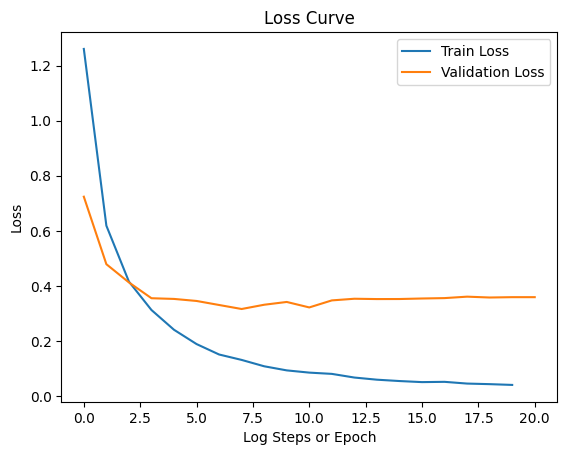

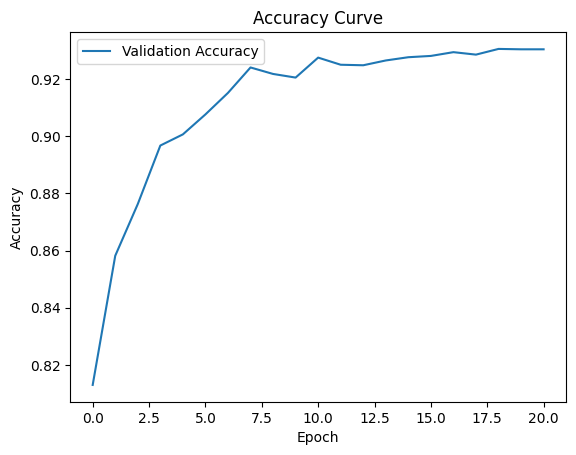

In [27]:
import matplotlib.pyplot as plt

plt.plot(recorder.train_losses, label="Train Loss")
plt.plot(recorder.eval_losses, label="Validation Loss")
plt.legend()
plt.title("Loss Curve")
plt.xlabel("Log Steps or Epoch")
plt.ylabel("Loss")
plt.show()

# plt.plot(recorder.train_accuracies, label="Train Accuracy")
plt.plot(recorder.eval_accuracies, label="Validation Accuracy")
plt.legend()
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [23]:
trainer.evaluate()

{'eval_loss': 0.3589390516281128,
 'eval_precision': 0.8269190325972661,
 'eval_recall': 0.8542255051053661,
 'eval_f1': 0.8403505022440693,
 'eval_accuracy': 0.9304489944159441,
 'eval_runtime': 0.6763,
 'eval_samples_per_second': 978.9,
 'eval_steps_per_second': 8.872,
 'epoch': 20.0}

In [24]:
predictions, labels, _ = trainer.predict(tokenized_dataset["test"])
predictions = np.argmax(predictions, axis=2)
# Remove ignored index (special tokens)
true_predictions = [
    [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

true_labels = [
    [label_names[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
results = metric.compute(predictions=true_predictions, references=true_labels)
# results
# true_predictions


In [25]:
true_predictions

[['B-SecTeam',
  'B-SecTeam',
  'B-SecTeam',
  'O',
  'O',
  'B-HackOrg',
  'B-HackOrg',
  'O',
  'B-HackOrg',
  'B-HackOrg',
  'B-HackOrg',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-HackOrg',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'],
 ['O',
  'O',
  'B-SecTeam',
  'B-SecTeam',
  'B-SecTeam',
  'O',
  'O',
  'O',
  'B-HackOrg',
  'B-HackOrg',
  'B-HackOrg',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'],
 ['B-SecTeam',
  'B-SecTeam',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-Area',
  'B-HackOrg',
  'B-HackOrg',
  'B-HackOrg',
  'I-HackOrg',
  'I-HackOrg',
  'O'],
 ['O',
  'O',
  'B-SecTeam',
  'B-SecTeam',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-HackOrg',
  'B-HackOrg',
  'B-HackOrg',
  'O'],
 ['O',
  'O',
  'O',
  'B-HackOrg',
  'B-HackOrg',
  'B-HackOrg',
  'O',
  'O',
  'B-SecTeam',
  'B-SecTeam',
  'B-SecTeam',
  'O',
  'O',
  'O',
  'O',

In [26]:
results

{'Area': {'precision': np.float64(0.8482490272373541),
  'recall': np.float64(0.8685258964143426),
  'f1': np.float64(0.8582677165354331),
  'number': np.int64(251)},
 'Exp': {'precision': np.float64(0.9913916786226685),
  'recall': np.float64(1.0),
  'f1': np.float64(0.9956772334293948),
  'number': np.int64(691)},
 'Features': {'precision': np.float64(0.8830409356725146),
  'recall': np.float64(0.993421052631579),
  'f1': np.float64(0.934984520123839),
  'number': np.int64(152)},
 'HackOrg': {'precision': np.float64(0.8242245199409158),
  'recall': np.float64(0.8913738019169329),
  'f1': np.float64(0.8564850345356869),
  'number': np.int64(626)},
 'Idus': {'precision': np.float64(0.8943661971830986),
  'recall': np.float64(0.8943661971830986),
  'f1': np.float64(0.8943661971830986),
  'number': np.int64(142)},
 'OffAct': {'precision': np.float64(0.8534031413612565),
  'recall': np.float64(0.7836538461538461),
  'f1': np.float64(0.8170426065162907),
  'number': np.int64(208)},
 'Org':

In [29]:
model_path = "bert-fine-tune-ner/results/checkpoint-6580"  # e.g., './distilbert-ner-model'
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForTokenClassification.from_pretrained(model_path)
model.eval()

DistilBertForTokenClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
   

In [ ]:
with open("test.txt", "r", encoding="utf-8") as f:
    lines = f.readlines()

sentences = []
current = []
for line in lines:
    if line.strip():
        token = line.strip().split()[0]
        current.append(token)
    else:
        if current:
            sentences.append(current)
            current = []
if current:
    sentences.append(current)

results = []
for sentence in sentences:
    inputs = tokenizer(sentence, is_split_into_words=True, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
    word_ids = inputs.word_ids()
    with torch.no_grad():
        outputs = model(**inputs)
    predictions = torch.argmax(outputs.logits, dim=2)[0].tolist()

    pred_labels = []
    previous_word_idx = None
    for idx, word_idx in enumerate(word_ids):
        if word_idx is None or word_idx == previous_word_idx:
            continue
        label_id = predictions[idx]
        pred_labels.append(label_names[label_id])
        previous_word_idx = word_idx

    results.append(list(zip(sentence, pred_labels)))

with open("predicted_test.txt", "w", encoding="utf-8") as f:
    for sentence in results:
        for word, label in sentence:
            f.write(f"{word} {label}\n")
        f.write("\n")